<a href="https://colab.research.google.com/github/Attol8/paintings-classifier/blob/master/Paintings_Classifier_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Paintings-Classifier

## Import libraries and set system up

In [0]:
from pathlib import Path
from fastai.vision import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from fastai import basic_train

from fastai.callbacks import *

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Download and Read Data

In [0]:
! pip install -q kaggle

In [0]:
! ls

data  gdrive  models


In [0]:
% cd gdrive/My\ Drive/fastai-v3/

/content/gdrive/My Drive/fastai-v3


In [0]:
! pwd

/content/gdrive/My Drive/fastai-v3


In [0]:
! ls

'Colab Notebooks'   data   kaggle.json	 models


In [0]:
! cp kaggle.json /content
% cd /content

/content


In [0]:
! ls

data  gdrive  kaggle.json  models


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
path = Path('data/')
path

PosixPath('data')

In [0]:
! kaggle datasets list -s [Artworks]

ref                                                   title                                       size  lastUpdated          downloadCount  
----------------------------------------------------  ------------------------------------------  ----  -------------------  -------------  
ikarus777/best-artworks-of-all-time                   Best Artworks of All Time                    2GB  2019-03-02 09:21:51           2112  
metmuseum/the-metropolitan-museum-of-art-open-access  The Metropolitan Museum of Art Open Access  28MB  2017-04-07 07:57:15            384  
rtatman/the-tate-collection                           The Tate Collection                          6MB  2017-08-18 22:16:15            411  
momanyc/museum-collection                             Museum of Modern Art Collection              6MB  2017-02-15 14:40:59           1273  
san-francisco/sf-sf-civic-art-collection              SF SF Civic Art Collection                  62KB  2019-01-02 22:38:46             22  


In [0]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time -p {path}

100% 2.16G/2.16G [00:38<00:00, 41.4MB/s]
100% 2.16G/2.16G [00:38<00:00, 59.6MB/s]


In [0]:
! unzip -q -n {path}/best-artworks-of-all-time.zip -d {path}

In [0]:
! unzip -q -n {path}/images.zip -d {path}

In [0]:
! rm {path}/images.zip
! rm {path}/best-artworks-of-all-time.zip
! rm {path}/resized.zip

In [0]:
df = pd.read_csv(path/'artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


##EDA

In [0]:
len(df)

50

In [0]:
by_nationality = df[['nationality', 'paintings']].groupby(['nationality'], as_index = False).sum()
nationality_top = by_nationality.sort_values('paintings', ascending = False)[:10]

count_names = df[['nationality', 'name']].groupby(['nationality']).count()
count_names = count_names.rename({'name' : 'number of artists'}, axis=1)

nationality_top = nationality_top.join(count_names, on = 'nationality')
print(nationality_top)

                 nationality  paintings  number of artists
6                     French       2120                 13
4                      Dutch       1360                  4
15                   Spanish       1099                  5
11                   Italian       1087                  8
14                   Russian        484                  4
5                    Flemish        356                  3
9                     German        328                  1
7             French,British        259                  1
8   French,Jewish,Belarusian        239                  1
0                   American        205                  2


In [0]:
by_genre = df[['genre', 'paintings']].groupby(['genre'], as_index = False).sum()
genre_top = by_genre.sort_values('paintings', ascending = False)[:10]

count_names = df[['genre', 'name']].groupby(['genre']).count()
count_names = count_names.rename({'name' : 'number of artists'}, axis=1)

genre_top = genre_top.join(count_names, on = 'genre')
print(genre_top)

                               genre  paintings  number of artists
10                     Impressionism       1370                  4
16                Post-Impressionism       1048                  4
14              Northern Renaissance        680                  4
1                            Baroque        586                  4
3                             Cubism        439                  1
22                       Romanticism        388                  3
30      Symbolism,Post-Impressionism        311                  1
17                       Primitivism        309                  2
8                   High Renaissance        301                  3
11  Impressionism,Post-Impressionism        277                  2


In [0]:
by_artist = df[['name', 'paintings']].groupby(['name'], as_index = False).sum()
name_top = by_artist.sort_values('paintings', ascending = False)[:20]
name_top

,name,paintings
48,Vincent van Gogh,877
10,Edgar Degas,702
33,Pablo Picasso,439
38,Pierre-Auguste Renoir,336
0,Albrecht Dürer,328
35,Paul Gauguin,311
15,Francisco Goya,291
42,Rembrandt,262
1,Alfred Sisley,259
46,Titian,255


In [0]:
# set variables

images_dir = path/'images'
artists = name_top['name'].str.replace(' ', '_').values

#let's give a look at some of these beautiful paintings !

def show_random_paintings(n_artists = 4, n_paintings = 4):
  
    fig, axes = plt.subplots(n_artists, n_paintings, figsize=(20,10))

    for r in range(n_artists):
        random_artist = random.choice(artists)
        random_images = random.sample(os.listdir(os.path.join(images_dir, random_artist)), n_paintings)

        c=0
        for random_image in random_images:

          random_image_file = os.path.join(images_dir, random_artist, random_image)
          image = plt.imread(random_image_file)

          axes[r, c].imshow(image)
          axes[r, c].set_title("Artist: " + random_artist.replace('_', ' '))
          axes[r, c].axis('off')

          c+=1

    return plt.show()

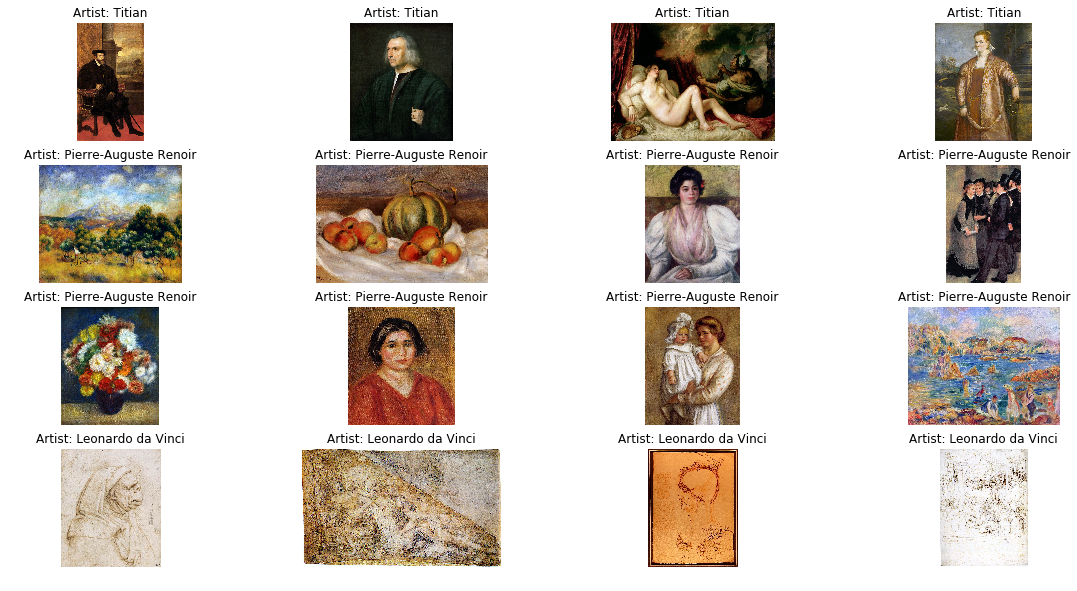

In [0]:
show_random_paintings()

##Training and Learning - ResNet34

In [0]:
artists

array(['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Dürer', 'Paul_Gauguin',
       'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall', 'Rene_Magritte', 'Amedeo_Modigliani',
       'Paul_Klee', 'Henri_Matisse', 'Andy_Warhol', 'Mikhail_Vrubel', 'Sandro_Botticelli', 'Leonardo_da_Vinci',
       'Peter_Paul_Rubens'], dtype=object)

In [0]:
path = 'data/images'
path

'data/images'

In [0]:
!ls {path}

Albrecht_Dürer	   Georges_Seurat	      Paul_Cezanne
Alfred_Sisley	   Giotto_di_Bondone	      Paul_Gauguin
Amedeo_Modigliani  Gustave_Courbet	      Paul_Klee
Andrei_Rublev	   Gustav_Klimt		      Peter_Paul_Rubens
Andy_Warhol	   Henri_de_Toulouse-Lautrec  Pierre-Auguste_Renoir
Camille_Pissarro   Henri_Matisse	      Pieter_Bruegel
Caravaggio	   Henri_Rousseau	      Piet_Mondrian
Claude_Monet	   Hieronymus_Bosch	      Raphael
Diego_Rivera	   Jackson_Pollock	      Rembrandt
Diego_Velazquez    Jan_van_Eyck		      Rene_Magritte
Edgar_Degas	   Joan_Miro		      Salvador_Dali
Edouard_Manet	   Kazimir_Malevich	      Sandro_Botticelli
Edvard_Munch	   Leonardo_da_Vinci	      Titian
El_Greco	   Marc_Chagall		      Vasiliy_Kandinskiy
Eugene_Delacroix   Michelangelo		      Vincent_van_Gogh
Francisco_Goya	   Mikhail_Vrubel	      William_Turner
Frida_Kahlo	   Pablo_Picasso


In [0]:
#Change Albrecht_Dürer name to Albrecht_Durer
!mv {path}/Albrecht_Dürer {path}/Albrecht_Durer
artists[4] = 'Albrecht_Durer'
artists

array(['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin',
       'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall', 'Rene_Magritte', 'Amedeo_Modigliani',
       'Paul_Klee', 'Henri_Matisse', 'Andy_Warhol', 'Mikhail_Vrubel', 'Sandro_Botticelli', 'Leonardo_da_Vinci',
       'Peter_Paul_Rubens'], dtype=object)

In [0]:
artists = np.delete(artists, 4)

In [0]:
artists, len(artists)

(array(['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Paul_Gauguin', 'Francisco_Goya',
        'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall', 'Rene_Magritte', 'Amedeo_Modigliani', 'Paul_Klee',
        'Henri_Matisse', 'Andy_Warhol', 'Mikhail_Vrubel', 'Sandro_Botticelli', 'Leonardo_da_Vinci', 'Peter_Paul_Rubens'],
       dtype=object), 19)

In [0]:
#bs,size=32, 128
#bs,size = 24,160
bs,size = 24,256
arch = models.resnet50

In [0]:
include = artists

src = (ImageList.from_folder(path)
.filter_by_folder(include=include)
.filter_by_func(lambda fname: Path(fname).suffix == '.jpg')
.split_by_rand_pct()
.label_from_folder())

In [0]:
src

In [0]:
data= (src.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data.classes

In [0]:
len(data.classes)

In [0]:
learn = cnn_learner(data, arch, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


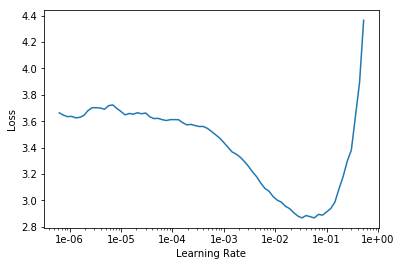

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#SaveModelCallback - Choosing every='improvement' saves the single best model out of all epochs during training. 
learn.fit_one_cycle(20, 5e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
0,1.552831,0.940522,0.727848,04:23
1,1.116943,0.809416,0.734177,04:17
2,1.015797,0.858739,0.726040,04:18
3,0.996166,0.946367,0.709765,04:16
4,1.149013,0.966787,0.706148,04:20
5,1.059283,0.880801,0.730561,04:28
6,0.960437,0.821575,0.734177,04:28
7,0.930996,0.760499,0.757685,04:27
8,0.850128,0.751953,0.756781,04:29
9,0.762222,0.685690,0.788427,04:29


Better model found at epoch 0 with accuracy value: 0.7278481125831604.
Better model found at epoch 1 with accuracy value: 0.7341772317886353.
Better model found at epoch 7 with accuracy value: 0.7576853632926941.
Better model found at epoch 9 with accuracy value: 0.7884267568588257.
Better model found at epoch 11 with accuracy value: 0.7965642213821411.
Better model found at epoch 12 with accuracy value: 0.8426762819290161.
Better model found at epoch 13 with accuracy value: 0.8526220321655273.
Better model found at epoch 14 with accuracy value: 0.8661844730377197.
Better model found at epoch 15 with accuracy value: 0.8788426518440247.
Better model found at epoch 16 with accuracy value: 0.8851717710494995.
Better model found at epoch 17 with accuracy value: 0.887884259223938.
Better model found at epoch 18 with accuracy value: 0.8896926045417786.


In [0]:
#function to load model from external source
def load_model(model_name):
  
  base_dir = Path(base_dir)
  model_path= Path(base_dir/model_name)
  return learn.load(model_path)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


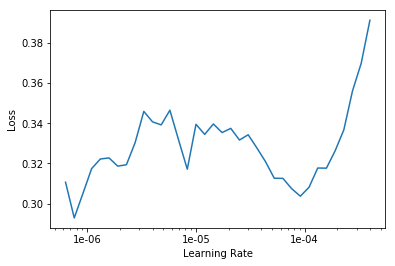

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-7,1e-6), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best-1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.299890,0.336243,0.891501,04:26
1,0.292627,0.339886,0.891501,04:30
2,0.292498,0.338625,0.890597,04:27
3,0.277034,0.338576,0.889693,04:30
4,0.287312,0.329575,0.899638,04:30


Better model found at epoch 0 with accuracy value: 0.8915008902549744.
Better model found at epoch 4 with accuracy value: 0.8996383547782898.


In [0]:
learn.load()

##Fixed VAL

In [0]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [0]:
include = artists

src = (ImageList.from_folder(path)
.filter_by_folder(include=include)
.filter_by_func(lambda fname: Path(fname).suffix == '.jpg')
.split_by_rand_pct()
.label_from_folder())

In [0]:
data= (src.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
len(data.classes)

19

In [0]:
def create_valid_csv():
  
    valid_list = data.valid_dl.items.tolist()
    valid_df = pd.DataFrame(valid_list)
    base_dir = Path(base_dir)
    valid_df.to_csv(base_dir/'valid.csv')

In [0]:
learn = cnn_learner(data, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 117182127.46it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


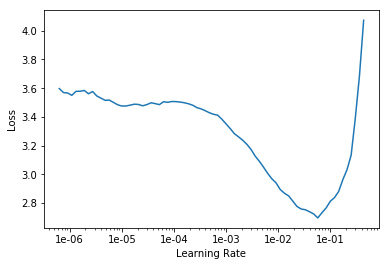

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#SaveModelCallback - Choosing every='improvement' saves the single best model out of all epochs during training. 
learn.fit_one_cycle(20, 5e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best-2')])

epoch,train_loss,valid_loss,accuracy,time
0,1.610727,0.949404,0.731465,04:28
1,1.116600,0.773409,0.765823,04:25
2,1.026863,0.752090,0.765823,04:24
3,1.091603,0.851718,0.739602,04:22
4,1.106174,0.915761,0.707052,04:21
5,1.128550,0.879033,0.714286,04:22
6,1.035721,0.886082,0.726040,04:23
7,0.955150,0.790775,0.763110,04:23
8,0.849871,0.698433,0.784810,04:23
9,0.770086,0.665397,0.786618,04:23


Better model found at epoch 0 with accuracy value: 0.7314647436141968.
Better model found at epoch 1 with accuracy value: 0.7658227682113647.
Better model found at epoch 8 with accuracy value: 0.7848101258277893.
Better model found at epoch 9 with accuracy value: 0.7866184711456299.
Better model found at epoch 11 with accuracy value: 0.8354430198669434.
Better model found at epoch 12 with accuracy value: 0.8679927587509155.
Better model found at epoch 14 with accuracy value: 0.8806509971618652.
Better model found at epoch 16 with accuracy value: 0.8960217237472534.
Better model found at epoch 18 with accuracy value: 0.9005424976348877.
Better model found at epoch 19 with accuracy value: 0.9023508429527283.
